<a href="https://colab.research.google.com/github/DrAlexSanz/Electricity-prices/blob/main/Electricity_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data is from [here](https://www.kaggle.com/dimitriosroussis/electricity-price-forecasting-with-dnns-eda/data)

Based on this: https://www.kaggle.com/dimitriosroussis/electricity-price-forecasting-with-dnns-eda/notebook

# Electricity price prediction

Based also on some conversations with Rodri and Dani and the extreme growth of the electricity prices in Autum 2021 in Europe, especially in Spain.

The data is from 2015 to 2019, this notebook doesn't aim to reproduce the prices in 2021/2022 because among other things I don't have the gas emissions rights data or the unit commitment program.

## Data description

In this dataset, we have two .csv files which contain hourly information about the electricity generation and weather in Spain for the period 2015-2019 (4 years).

* ``` weather_features.csv ```: Contains hourly information about the weather conditions (e.g. temperature, wind speed, humidity, rainfall, qualitative desctiption) of 5 major cities in Spain (Madrid, Barcelona, Valencia, Seville and Bilbao).

* ``` energy_dataset.csv ```: Contains hourly information about the generation of energy in Spain. In particular, there is info (in MW) about the amount of electricty generated by the various energy sources as well as about the total load (energy demand) of the national grid and the price of energy (€/MWh). Since it's an hourly dataset and the generation is in MW, the data is in MWh.

The information that we have about the weather of 5 major cities in Spain (highlighted by a red star on the map below) is probably more than enough for our analysis. Anyway I'm not going to solve the electricity market in Spain. For my testing purpose it should be enough.

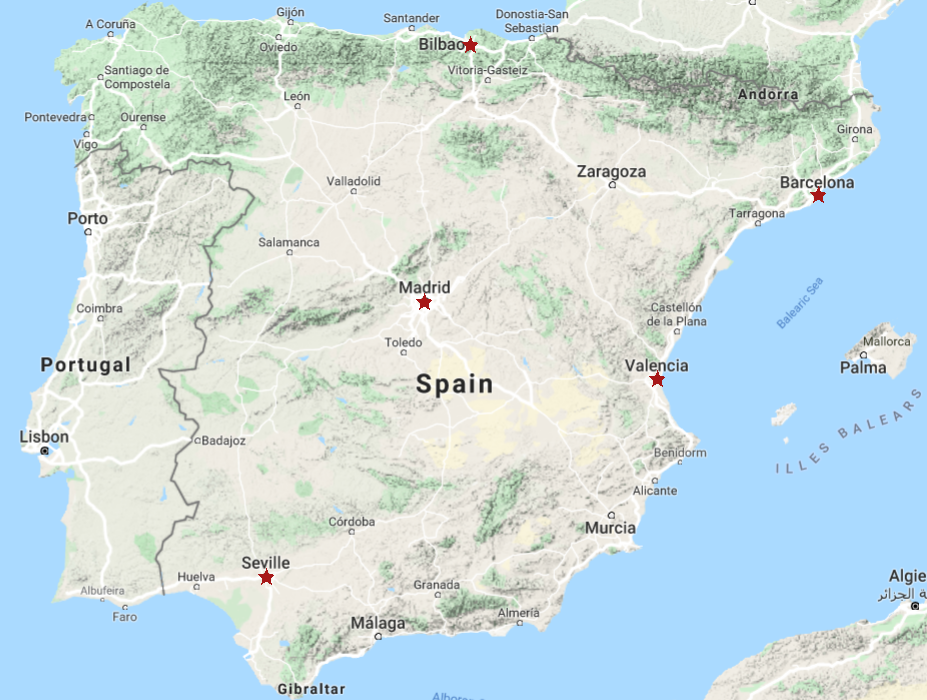

### Read the data from google drive. It's already in csv format.

In [1]:
import pandas as pd
from google.colab import drive
import seaborn as sns
import numpy as np

In [21]:
drive.mount('/gdrive')

weather = pd.read_csv('/gdrive/MyDrive/Electricity_prices/weather_features.csv')
energy = pd.read_csv('/gdrive/MyDrive/Electricity_prices/energy_dataset.csv')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [22]:
# Data description
weather.columns

Index(['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h',
       'clouds_all', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon'],
      dtype='object')

The weather dataset contains:
* dt_iso: date information
* city_name: I checked that the cities are the correct ones.
* temp: temperature in K.
* temp_min/temp_max: is the min/max daily temperature
* pressure, humidity (as a %), wind_speed, wind_deg are self explanatory.
* rain_1h, rain_3h, snow_3h contains the rain/snow int he last 1/3h.
* weatherid is a code and the cloud cover seems to be also a %.


In [23]:
weather.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,178396.000000,178396.000000,178396.000000,1.783960e+05,178396.000000,178396.00000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000,178396.000000
mean,289.618605,288.330442,291.091267,1.069261e+03,68.423457,2.47056,166.591190,0.075492,0.000380,0.004763,25.073292,759.831902
std,8.026199,7.955491,8.612454,5.969632e+03,21.902888,2.09591,116.611927,0.398847,0.007288,0.222604,30.774129,108.733223
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.670000,282.483602,284.650000,1.013000e+03,53.000000,1.00000,55.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.00000,177.000000,0.000000,0.000000,0.000000,20.000000,800.000000
75%,295.150000,293.730125,297.150000,1.022000e+03,87.000000,4.00000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.00000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


There seems to be an outlier in Pressure (10 MPa), in wind speed (133 m/s). There is also something fishy with the rain_1h and rain_3h, the maximum rain 1h is higher than the maximum rain_3h. I will probably drop rain_3h because I can. It is an hourly market anyway.

In [24]:
weather.drop(["rain_3h", "weather_id", "temp_min", "temp_max", "weather_description", "weather_icon", "weather_main"], axis = 1, inplace = True)

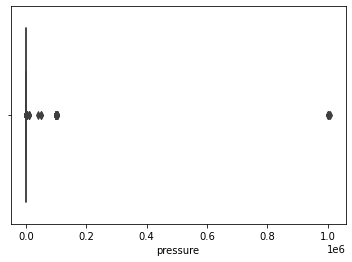

In [25]:
%matplotlib inline
sns.boxplot(x = weather.pressure)

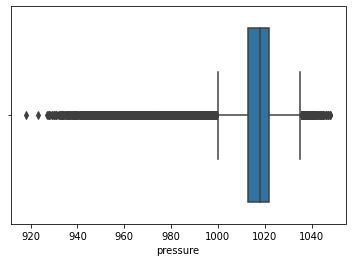

In [26]:
# Let's put anything above 1.05 MPa as NaN and then interpolate. Also anything below 0.9 MPa. It's not the perfect method but it will catch most of the outliers.

weather.loc[weather["pressure"] > 1050, "pressure"] = np.nan
weather.loc[weather["pressure"] < 900, "pressure"] = np.nan

# And now it's much better
sns.boxplot(x = weather.pressure)

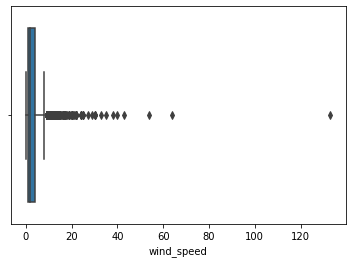

In [27]:
sns.boxplot(x = weather.wind_speed)

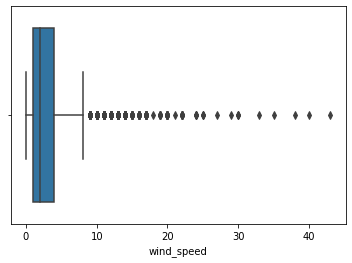

In [28]:
# Oula! Anything over 40-50 we can probably discard. Last tornado was in Gandía in 2012.

weather.loc[weather["wind_speed"] > 50, "wind_speed"] = np.nan
weather.loc[weather["wind_speed"] < 0, "wind_speed"] = np.nan # For negative wind speeds we have the angle

sns.boxplot(x = weather.wind_speed)

### Now let's interpolate the NaNs that I filled before.

In [29]:
weather.interpolate(method = "linear", limit_direction = "both", inplace = True, axis = 0)

# And we need to check for duplicates. I'll do it by city and keep only the first row if I find duplicates.

In [30]:
temp_weather = weather.duplicated(keep='first').sum()
print("There are " + str(temp_weather) + " duplicated rows in the weather dataset")

# I want to drop all the duplicate time/city combinations and then reset the index, using the time as index

weather.drop_duplicates(subset = ["city_name", "dt_iso"], inplace = True, keep = "first")
weather.set_index(keys = "dt_iso", inplace = True)

temp_weather = weather.duplicated(keep='first').sum()


There are 3076 duplicated rows in the weather dataset


## Let's do something similar with the energy file